<a href="https://colab.research.google.com/github/burakemretetik/makemore/blob/main/makemore_mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## MLP

## Setup

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open("names.txt", "r").read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [3]:
# Build the vocabulary of characters
chars = sorted(list(set("".join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i:s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [4]:
# Build the dataset

def build_dataset(words, display = False, n_samples = len(words)):
  block_size = 3 # Context length: how many characters do we take to predict the next one
  X, Y = [], []

  for w in words[:n_samples]:
      context = [0] * block_size
      for ch in w + ".":
          ix = stoi[ch]
          X.append(context)
          Y.append(ix)
          if display == True: print(''.join(itos[i] for i in context), '--->', itos[ix])
          context = context[1:] + [ix] # Crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

X, Y = build_dataset(words, n_samples = 5, display = True)

... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
... ---> a
..a ---> v
.av ---> a
ava ---> .
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .
torch.Size([32, 3]) torch.Size([32])


In [5]:
X[:3], Y[:3] # X's are 3 letter sequances in the words, and Y's are the next letter comes after them. (Encoded with integeres from 0 = '.' to 26 = 'z)

(tensor([[ 0,  0,  0],
         [ 0,  0,  5],
         [ 0,  5, 13]]),
 tensor([ 5, 13, 13]))

In [6]:
# Set the parameters
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
  p.requires_grad = True

In [7]:
C[:5] # C, represents each letter as 2D vector. We're going to adjust it with training.

tensor([[ 1.5674, -0.2373],
        [-0.0274, -1.1008],
        [ 0.2859, -0.0296],
        [-1.5471,  0.6049],
        [ 0.0791,  0.9046]], grad_fn=<SliceBackward0>)

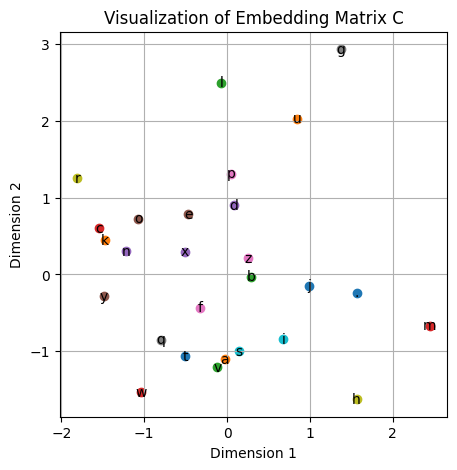

In [8]:
C_initial = C
# Visiualize the embedding: C
plt.figure(figsize=(5, 5))
for i in range(C.shape[0]):
    plt.scatter(C[i, 0].item(), C[i, 1].item())
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha='center', va='center')
plt.title("Visualization of Embedding Matrix C")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(True)
plt.show()

In [9]:
for _ in range(20):
  # Forward pass
  emb = C[X] #(32, 3, 2)
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # h=(32,100) . W=(100,27)
  counts = logits.exp()
  prob = counts / counts.sum(1, keepdims=True)
  loss = -prob[torch.arange(32), Y].log().mean() # Cross entrophy
  print(loss.item())

  # Backward pass
  for p in parameters:
      p.grad = None
  loss.backward()

  # Update
  for p in parameters:
      p.data += -0.5 * p.grad

17.769710540771484
9.423107147216797
8.315449714660645
6.3887176513671875
3.5150113105773926
4.386329174041748
2.3290441036224365
1.834228515625
2.4214422702789307
2.067513942718506
2.038220167160034
2.338480234146118
2.3126628398895264
0.8481928110122681
0.6379550099372864
0.480983167886734
0.5474133491516113
0.5514250993728638
0.6425767540931702
0.4172671437263489


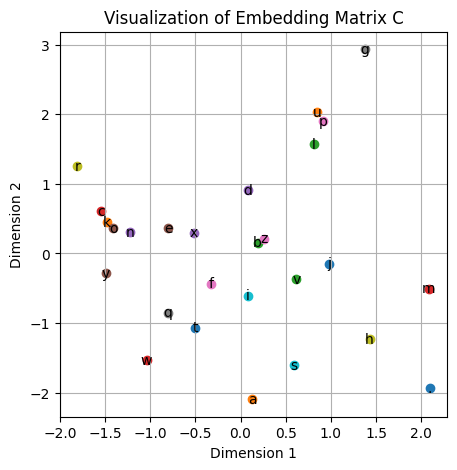

In [10]:
plt.figure(figsize=(5, 5))  # Adjust figure size as needed
for i in range(C.shape[0]):
    plt.scatter(C[i, 0].item(), C[i, 1].item())
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha='center', va='center')
plt.title("Visualization of Embedding Matrix C")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(True)
plt.show()

Note: we're overfitting the model here (too few examples for a large dataset will result poor in the actual data)

## Adjust

In [11]:
# Rebuild the dataset (with full data)

X, Y = build_dataset(words, display = False)

torch.Size([228146, 3]) torch.Size([228146])


In [12]:
# Setup parameters
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

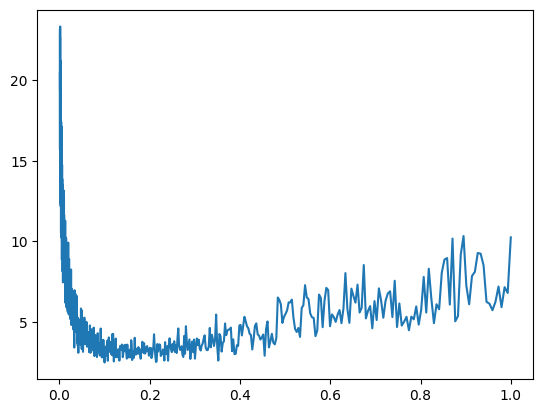

In [13]:
# Deciding leanring rate
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

lri = []
lossi = []

for i in range(1000):
  # Minibatch
  ix = torch.randint(0, X.shape[0], (32,))

  # Forward pass
  emb = C[X[ix]] #(32, 3, 2)
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # h=(32,100) . W=(100,27)
  loss = F.cross_entropy(logits, Y[ix])

  # Backward pass
  for p in parameters:
      p.grad = None
  loss.backward()

  # Update
  lr = lrs[i]
  for p in parameters:
      p.data += -lr * p.grad

  # Track the stats
  lri.append(lr)
  lossi.append(loss.item())

plt.plot(lri, lossi)

It looks like 0.1 is a good learning rate to initialize.

## Train

In [14]:
# Reset parameters
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [15]:
lr = 0.1
losses = []
lrs = []

for _ in range(5):
  lrs.append(lr)
  for i in range(100):
    # Minibatch
    ix = torch.randint(0, X.shape[0], (32,), generator = g)

    # Forward pass
    emb = C[X[ix]] #(32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # h=(32,100) . W=(100,27)
    loss = F.cross_entropy(logits, Y[ix])

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update
    for p in parameters:
        p.data += -lr * p.grad

    # Track
    losses.append(loss.item())

  lr = lr * 0.75
  print(loss.item())

3.682828426361084
2.7850520610809326
2.9104599952697754
2.733823299407959
2.856456995010376


[0.1,
 0.07500000000000001,
 0.05625000000000001,
 0.0421875,
 0.031640625000000006]

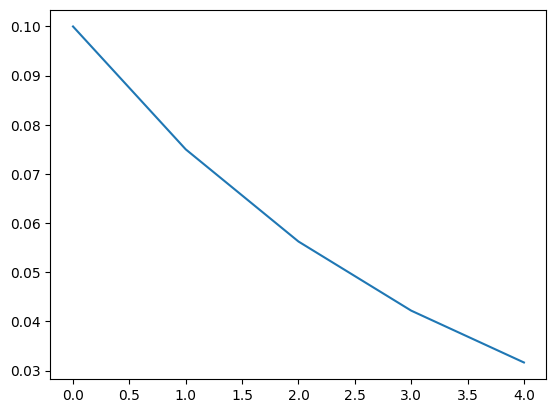

In [16]:
plt.plot(lrs) # Learning rate decay (100 update for each learing rate below.)
lrs

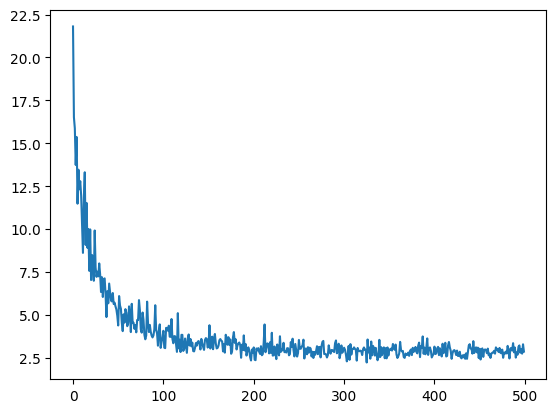

In [17]:
plt.plot(losses)

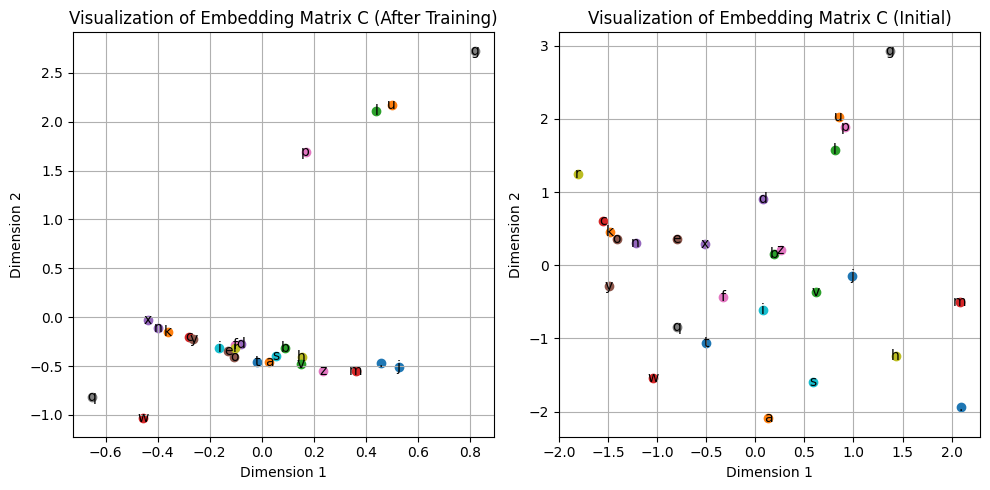

In [18]:
# Create a figure with two subplots (1 row, 2 columns)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))  # Adjust figsize as needed

# Plot C on the first subplot (ax1)
for i in range(C.shape[0]):
    ax1.scatter(C[i, 0].item(), C[i, 1].item())
    ax1.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha='center', va='center')
ax1.set_title("Visualization of Embedding Matrix C (After Training)")
ax1.set_xlabel("Dimension 1")
ax1.set_ylabel("Dimension 2")
ax1.grid(True)

# Plot C_initial on the second subplot (ax2)
for i in range(C_initial.shape[0]):
    ax2.scatter(C_initial[i, 0].item(), C_initial[i, 1].item())
    ax2.text(C_initial[i, 0].item(), C_initial[i, 1].item(), itos[i], ha='center', va='center')
ax2.set_title("Visualization of Embedding Matrix C (Initial)")
ax2.set_xlabel("Dimension 1")
ax2.set_ylabel("Dimension 2")
ax2.grid(True)

# Adjust layout to prevent overlapping
plt.tight_layout()

# Display the plots
plt.show()

### Train & Test

In [19]:
# Train, test, validation splits = (%80, %10, %10)
X, Y = build_dataset(words)
import random

random.seed(42)
random.shuffle(words)

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

X_train, Y_train = X[:n1], Y[:n1]
X_test, Y_test = X[n1:n2], Y[n1:n2]
X_val, Y_val = X[n2:], Y[n2:]

torch.Size([228146, 3]) torch.Size([228146])


In [20]:
# Reset parameters
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [21]:
lr = 0.1
losses = []
lrs = []

for _ in range(10):
  lrs.append(lr)
  for i in range(200):
    # Minibatch
    ix = torch.randint(0, X_train.shape[0], (32,), generator = g)

    # Forward pass
    emb = C[X_train[ix]] #(32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # h=(32,100) . W=(100,27)
    loss = F.cross_entropy(logits, Y_train[ix])

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update
    for p in parameters:
        p.data += -lr * p.grad

    # Track
    losses.append(loss.item())

  lr = lr * 0.8
  print(loss.item())

3.2657248973846436
2.29642391204834
2.265455961227417
2.9550671577453613
2.5645041465759277
2.741131067276001
2.6132090091705322
2.4129695892333984
2.81276273727417
2.4314606189727783


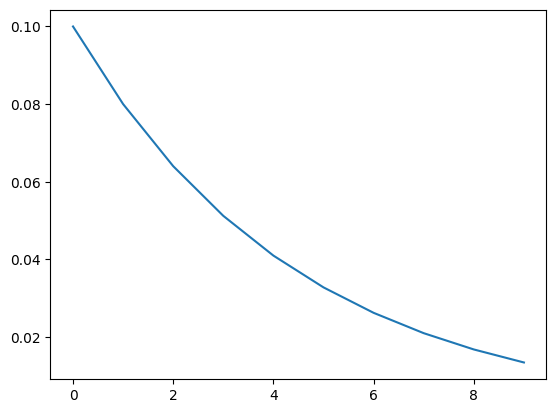

In [22]:
plt.plot(lrs) # Learning rate decay

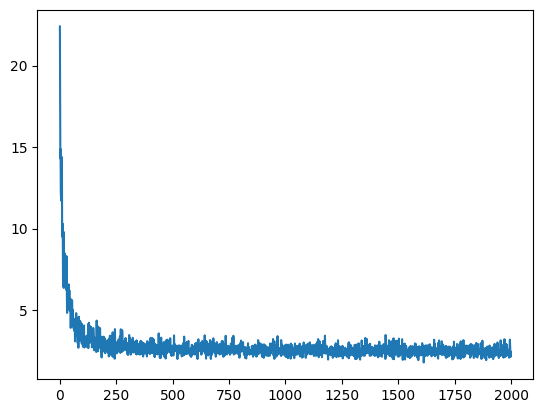

In [23]:
plt.plot(losses)

In [24]:
# Evaluate
emb = C[X_test] #(32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # h=(32,100) . W=(100,27)
loss = F.cross_entropy(logits, Y_test)
loss

tensor(2.5169, grad_fn=<NllLossBackward0>)

### Scale Up the Network

In [110]:
# Scale up the neurons 100 -> 300
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [111]:
lr = 0.1
losses = []
lrs = []

for _ in range(5):
  lrs.append(lr)
  for i in range(10000):
    # Minibatch
    ix = torch.randint(0, X_train.shape[0], (32,), generator = g)

    # Forward pass
    emb = C[X_train[ix]] #(32, 3, 2)
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # h=(32,100) . W=(100,27)
    loss = F.cross_entropy(logits, Y_train[ix])

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update
    for p in parameters:
        p.data += -lr * p.grad

    # Track
    losses.append(loss.item())

  lr = lr * 0.8
  print(loss.item())

2.1063196659088135
2.1721231937408447
1.5869210958480835
1.896622896194458
1.8299331665039062


In [112]:
# Evaluate
emb = C[X_test] #(32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # h=(32,100) . W=(100,27)
loss = F.cross_entropy(logits, Y_test)
loss

tensor(2.2295, grad_fn=<NllLossBackward0>)

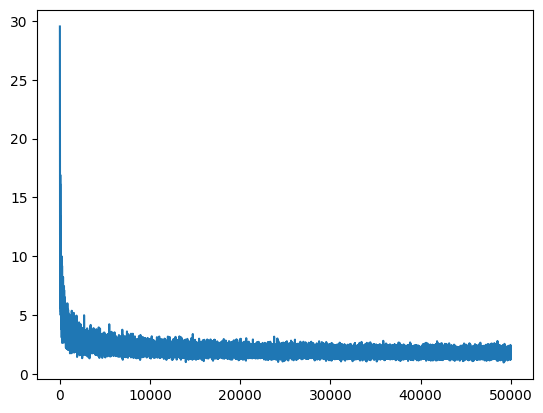

In [104]:
plt.plot(losses)

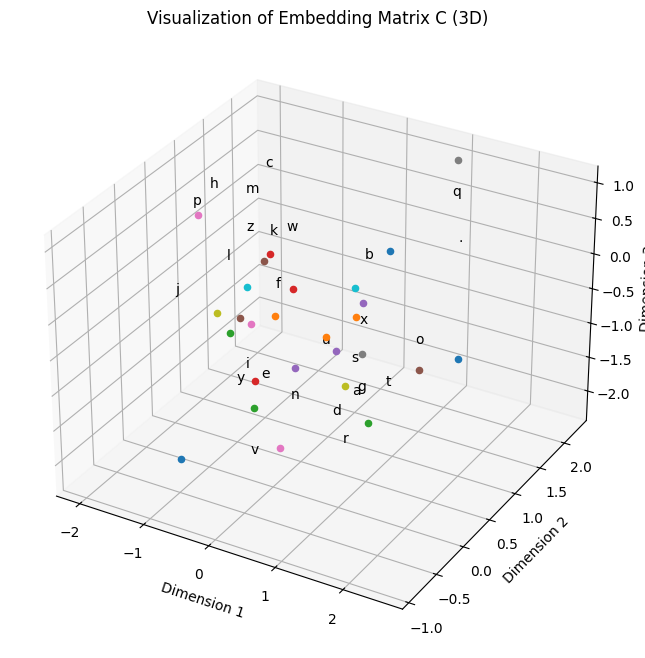

In [106]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Import for 3D plotting

fig = plt.figure(figsize=(8, 8))  # Adjust figure size as needed
ax = fig.add_subplot(111, projection='3d')  # Create a 3D subplot

for i in range(C.shape[0]):
    ax.scatter(C[i, 0].item(), C[i, 1].item(), C[i, 2].item())  # Scatter plot in 3D
    ax.text(C[i, 0].item(), C[i, 1].item(), C[i, 2].item(), itos[i], ha='center', va='center')  # Text labels in 3D

ax.set_title("Visualization of Embedding Matrix C (3D)")  # Set title
ax.set_xlabel("Dimension 1")  # Set x-axis label
ax.set_ylabel("Dimension 2")  # Set y-axis label
ax.set_zlabel("Dimension 3")  # Set z-axis label
plt.grid(True)  # Add grid
plt.show()  # Display the plot

### Sample from the model

In [117]:
g = torch.Generator().manual_seed(2147483647 + 10)
block_size = 3

for _ in range(20):
  out = []
  context = [0] * block_size
  while True:
    emb = C[torch.tensor([context])]
    h = torch.tanh(emb.view(1, -1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1, generator=g).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break

  print(''.join(itos[i] for i in out))

mona.
mayah.
ree.
melin.
aleigh.
regendra.
gra.
chel.
eline.
milah.
remelisson.
arleigh.
mckarlin.
sherengfia.
jest.
julietlyn.
josella.
uecholet.
kylene.
els.
